# Self-Driving Car Engineer Nanodegree

## Computer Vision

### Project: Build a pipeline for lane line detection

The code in this notebook implements the steps necessary to detect the lane lines on the road. The comments explain the individual steps.

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

  

* Encapcsulate image processing steps in functions.
* Apply image processing chain on a video.

## Camera Calibration

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Chessboard meta data (horizontal and vertical corners)
chess_corner_hor = 9
chess_corner_ver = 6

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ..., (8,5,0)
objp = np.zeros((chess_corner_ver*chess_corner_hor,3), np.float32)
objp[:,:2] = np.mgrid[0:chess_corner_hor,0:chess_corner_ver].T.reshape(-1,2) # x,y coordinates

for fname in images:
    # read in each image
    img = mpimg.imread(fname)
    # convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_corner_hor,chess_corner_ver),None)
    
    # if corners are found, add object points and image points
    if (True == ret):
        imgpoints.append(corners)
        objpoints.append(objp)

# return value, distortion camera matrix, distortion coefficients, rotation and translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

'''
Note that the calibration matrix is a global variable and used globally from now on
Not passed as an argument - what would be an alternative
'''

# end of camera calibration

'\nNote that the calibration matrix is a global variable and used globally from now on\nNot passed as an argument - what would be an alternative\n'

### Applying camera calibration data - Undistortion

In [2]:
sample_distorted = mpimg.imread(images[-1])
sample_undistorted = cv2.undistort(sample_distorted, mtx, dist, None, mtx)

#### Distorted chessboard image

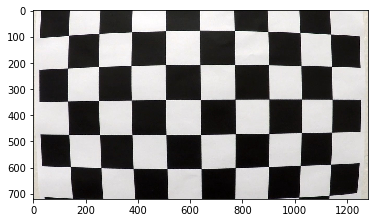

In [3]:
_ = plt.imshow(sample_distorted)

#### Undistorted chessboard image

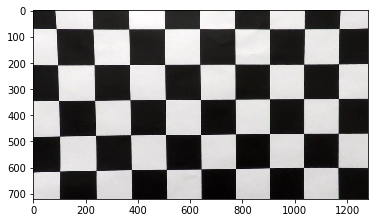

In [4]:
_ = plt.imshow(sample_undistorted)

# save the image (required by project rubric)
plt.imsave('output_images/undistorted_chessboard.png', sample_undistorted)

Now that we have undistortion applied to chessboard image we can undistort an example image

#### Distorted example image

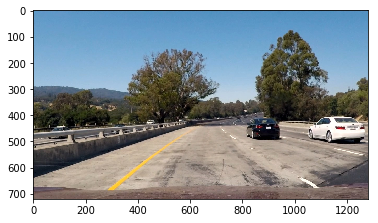

In [5]:
sample_image_distorted = mpimg.imread('test_images/test1.jpg')
_ = plt.imshow(sample_image_distorted)

#### Undistorted example image

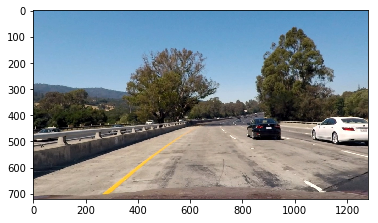

In [6]:
sample_image_undistorted = cv2.undistort(sample_image_distorted, mtx, dist, None, mtx)
_ = plt.imshow(sample_image_undistorted)

# save the image (required by project rubric)
plt.imsave('output_images/undistorted_sample.png', sample_image_undistorted)

## Creating a thresholded binary image

The function below creates a combined thresholded image - it has combined both gradient and color thresholds into one image.

In [7]:
def combinedBinaryThreshold(img, s_thresh=(125, 255), sx_thresh=(20, 255)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold 1: x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold 2: color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    # Combined Binary Threshold by "OR-ing" both individual results
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

### Testing combined binary threshold on a sample image

In [8]:
img = mpimg.imread('test_images/test5.jpg')

#### Sample image (original)

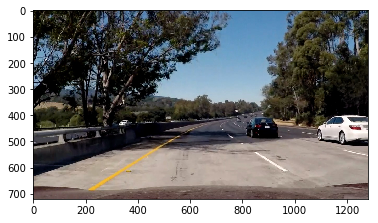

In [9]:
_ = plt.imshow(img)

#### Sample image (binary threshold - and undistortion before)

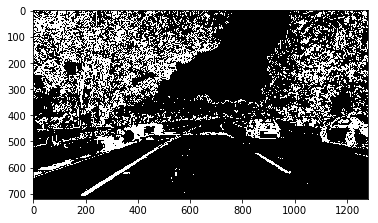

In [10]:
# undistort (what was done in the first step above)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
# apply binary threshold for lane line detection
binaryThreshold = combinedBinaryThreshold(undistorted)

_ = plt.imshow(binaryThreshold, cmap='gray')

# save the image (required by project rubric)
plt.imsave('output_images/binary_threshold.png', binaryThreshold, cmap=plt.cm.gray)

## Perspective transform to rectify the binary image

The following function implements warping

In [11]:
def warp(input):
    corners_src = np.float32([[190,720],[585,458],[698,458],[1145,720]])

    new_width_shrink_offset=np.float32([200,0])
    img_size = (input.shape[1], input.shape[0])

    corner_dst_bottom_left  = corners_src[0]+new_width_shrink_offset
    corner_dst_top_left     = [corners_src[0,0],0]+new_width_shrink_offset
    corner_dst_top_right    = [corners_src[3,0],0]-new_width_shrink_offset
    corner_dst_bottom_right = corners_src[3]-new_width_shrink_offset

    corners_dst = np.float32([corner_dst_bottom_left, corner_dst_top_left, corner_dst_top_right, corner_dst_bottom_right])
    
    M = cv2.getPerspectiveTransform(corners_src, corners_dst)
    Minv = cv2.getPerspectiveTransform(corners_dst, corners_src)
    warped = cv2.warpPerspective(input, M, (input.shape[1], input.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

Showing an examle of straight lines (original and warped)

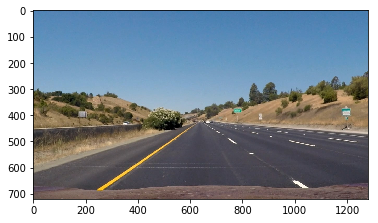

In [12]:
img = mpimg.imread('test_images/straight_lines1.jpg')
_ = plt.imshow(img)

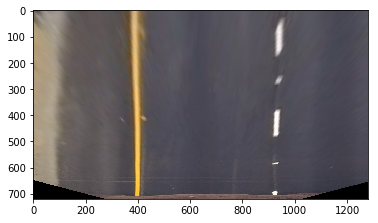

In [13]:
warped, M, Minv = warp(img)
_ = plt.imshow(warped)

# save the image (required by project rubric)
plt.imsave('output_images/warped.png', warped)

## Detecting lane pixels and fitting to find the lane boundary

The following lines apply the steps so far

* Load an image
* Undistort
* Create combined binary threshold
* warp the result

Example pictures for the last two steps

In [14]:
img = mpimg.imread('test_images/test5.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
combinedBinary = combinedBinaryThreshold(undistorted)
warped = cv2.warpPerspective(combinedBinary, M, (combinedBinary.shape[1], combinedBinary.shape[0]), flags=cv2.INTER_LINEAR)

Combined binary image

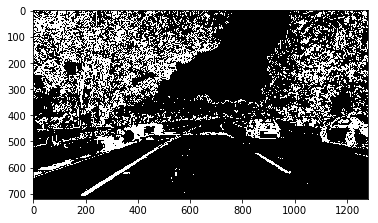

In [15]:
_ = plt.imshow(combinedBinary, cmap='gray')

Warped image based on binary threshold

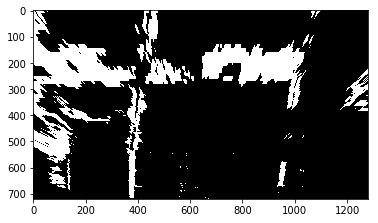

In [16]:
_ = plt.imshow(warped, cmap='gray')

The following function detects lane lines on a binary 

In [17]:
def find_lane_lines(warped, left_fit, right_fit, tracked=False):
    bottom_half = warped[warped.shape[0]//2:,:].astype(float)
    ''' 
    Originally bottom_half was a binary image, I transformed it to float.
    I apply a filter mask to make use of a priori knowledge in order
    to suppress disturbances from shadows and other edges.
    Probability that the starting point is in the defined area is 
    a certain percentage higher than anywhere else
    Note: This does not apply and work any more when performaning lane changes!
    But for lane driving it works very well
    '''
    
    mask = np.ones(warped.shape[1])
    apriori = 1.85
    mask[300:450] = apriori 
    mask[850:1200] = apriori
    newbase = np.multiply(bottom_half,mask)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(newbase, axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if (tracked==False):
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 80
        # Set minimum number of pixels found to recenter window
        minpix = 30
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
    
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    
    else:
        margin = 15
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    center = out_img.shape[1]/2
    dy_left = (center-leftx[0])
    dy_right = -(rightx[0]-center)
    center_deviation = (dy_left+dy_right)*xm_per_pix*100/2
    lane_width = (dy_left - dy_right)*xm_per_pix
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty, out_img, left_curverad, right_curverad, dy_left, dy_right, center_deviation, lane_width

In [18]:
left_fit = None
right_fit = None
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img, left_curverad, right_curverad, dy_left, dy_right, center_deviation, lane_width = find_lane_lines(warped, left_fit, right_fit, tracked=False)

Example images with line pixels identified and a fit overplotted 

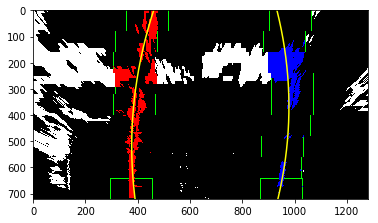

In [19]:
_ = plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# save the image (required by project rubric)
plt.imsave('output_images/line_pixels_and_fit.png', out_img)

Deviation from center ("+" means to the right, "-" means to the left)

In [20]:
print(center_deviation, "cm")

-7.4 cm


## Warp the detected lane boundaries back onto the original image

Helper class (basicaly misused as a C struct) to store lane data
* left curve radius
* right curve radius
* center deviation

In [21]:
class lanedata:
    def __init__(self, curv_left, curv_right, center_dev):
        self.radius_left = curv_left
        self.radius_right = curv_right
        self.center_deviation = center_dev

In [22]:
lane_data = lanedata(left_curverad,right_curverad,center_deviation)

In [23]:
def drawLaneOnImage(left_fitx, right_fitx, lane_data, originalToDrawOn):
    # Create an image to draw the lines on
    warp_zero = np.zeros((originalToDrawOn.shape[0],originalToDrawOn.shape[1])).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (originalToDrawOn.shape[1], originalToDrawOn.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(originalToDrawOn, 1, newwarp, 0.3, 0)
    
    # Adding text from lane_data (radius and center_deviation)  
    curvature_text = "Radius"
    curvature_left = "Left = " + str(np.round(lane_data.radius_left, 2)) 
    curvature_lright = "Right = " + str(np.round(lane_data.radius_right, 2)) 
    curvature_mean = "Mean = " + str(np.round((lane_data.radius_left+lane_data.radius_right)/2,2))
    deviation_text = "Center deviation =" + str(np.round(lane_data.center_deviation,2)) + "cm"
    
    font = cv2.FONT_HERSHEY_SIMPLEX   
    cv2.putText(result, curvature_text, (30, 30), font, 1, (255,255,255), 2)
    cv2.putText(result, curvature_left, (30, 60), font, 1, (255,255,255), 2)
    cv2.putText(result, curvature_lright, (30, 90), font, 1, (255,255,255), 2)    
    cv2.putText(result, curvature_mean, (30, 120), font, 1, (255,255,255), 2)    
    cv2.putText(result, deviation_text, (30, 180), font, 1, (255,255,255), 2)    
    
    return result

Example of a layered image with detected lane defined by left and right line , estimated curvature and deviation from center on the top left

The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries.

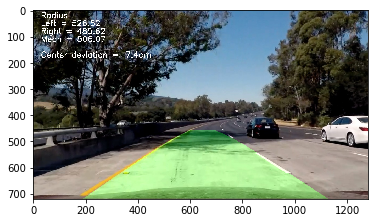

In [24]:
result = drawLaneOnImage(left_fitx, right_fitx, lane_data, undistorted) 
_ = plt.imshow(result)

# save the image (required by project rubric)
plt.imsave('output_images/result_layered_lane_boundaries.png', result)

## Encapcsulate image processing steps in functions

Define processing chain

* undistort
* binary threshold
* warp
* find lines
* draw on image

In [25]:
tracked = False
left_fit = None
right_fit = None

def process_image(input):
    undistorted = cv2.undistort(input, mtx, dist, None, mtx)
    combined_binary = combinedBinaryThreshold(undistorted)
    warped, M, Minv = warp(combined_binary)
    global left_fit
    global right_fit
    global tracked
    
    left_fit, right_fit, left_fitx, right_fitx, ploty, out_img, left_curverad, right_curverad, dy_left, dy_right, center_deviation, lane_width = find_lane_lines(warped, left_fit, right_fit, tracked)
    
    #sanity check
    if ((np.abs((left_curverad/right_curverad))<2) or (np.abs((left_curverad/right_curverad))>0.5)) and lane_width < 3.9:
        tracked = True
    else:
        tracked = False
     
    lane_data = lanedata(left_curverad,right_curverad,center_deviation)
    result = drawLaneOnImage(left_fitx, right_fitx, lane_data, undistorted)
    
    return result

Test processing chain on single image

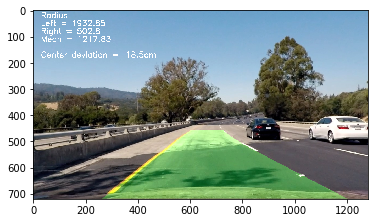

In [ ]:
test_image = mpimg.imread('test_images/test4.jpg')
result = process_image(test_image)
_ = plt.imshow(result)

### Apply whole chain on a video

In [ ]:
from collections import deque
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

tracked = False
video_output = "output_images/projct_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image)
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/projct_output.mp4
[MoviePy] Writing video output_images/projct_output.mp4


 84%|████████▍ | 1059/1261 [02:22<00:27,  7.39it/s]